# Hyperparameter Optimization Methods Comparison

This notebook demonstrates and compares Grid Search, Random Search, and Bayesian Optimization.

## Setup and Imports

In [2]:
!pip install optuna

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
import time
import matplotlib.pyplot as plt
from scipy.stats import uniform, loguniform

# Set random seed
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.5/599.5 kB 70.6 MB/s eta 0:00:00


## 1. Data Preparation

In [3]:
# Generate synthetic dataset
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Grid Search Implementation

In [4]:
def grid_search_cv():
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }
    
    grid_search = GridSearchCV(
        SVC(),
        param_grid,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    start_time = time.time()
    grid_search.fit(X_train_scaled, y_train)
    duration = time.time() - start_time
    
    return grid_search.best_params_, grid_search.best_score_, duration

## 3. Random Search Implementation

In [5]:
def random_search_cv():
    param_distributions = {
        'C': loguniform(0.1, 100),
        'kernel': ['linear', 'rbf'],
        'gamma': uniform(0.1, 1)
    }
    
    random_search = RandomizedSearchCV(
        SVC(),
        param_distributions,
        n_iter=32,  # Same number of evaluations as grid search
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    start_time = time.time()
    random_search.fit(X_train_scaled, y_train)
    duration = time.time() - start_time
    
    return random_search.best_params_, random_search.best_score_, duration

## 4. Bayesian Optimization Implementation

In [6]:
def objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 0.1, 100),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
        'gamma': trial.suggest_loguniform('gamma', 0.1, 1)
    }
    
    model = SVC(**params)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    return score.mean()

def bayesian_optimization():
    start_time = time.time()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=32)  # Same number of evaluations
    duration = time.time() - start_time
    
    return study.best_params, study.best_value, duration

## 5. Compare Methods

[I 2024-10-28 19:52:46,435] A new study created in memory with name: no-name-7ab7933e-e5cc-4840-917f-d0475a61a605
/tmp/ipykernel_3816203/532893349.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 0.1, 100),
/tmp/ipykernel_3816203/532893349.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.1, 1)
[I 2024-10-28 19:52:46,468] Trial 0 finished with value: 0.805 and parameters: {'C': 0.3010826366321718, 'kernel': 'linear', 'gamma': 0.20601801134887512}. Best is trial 0 with value: 0.805.
/tmp/ipykernel_3816203/532893349.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Th

Results Comparison:
          Method  Best Score  Time (s)
0    Grid Search     0.95375  1.451579
1  Random Search     0.96250  0.349471
2   Bayesian Opt     0.96375  4.540321


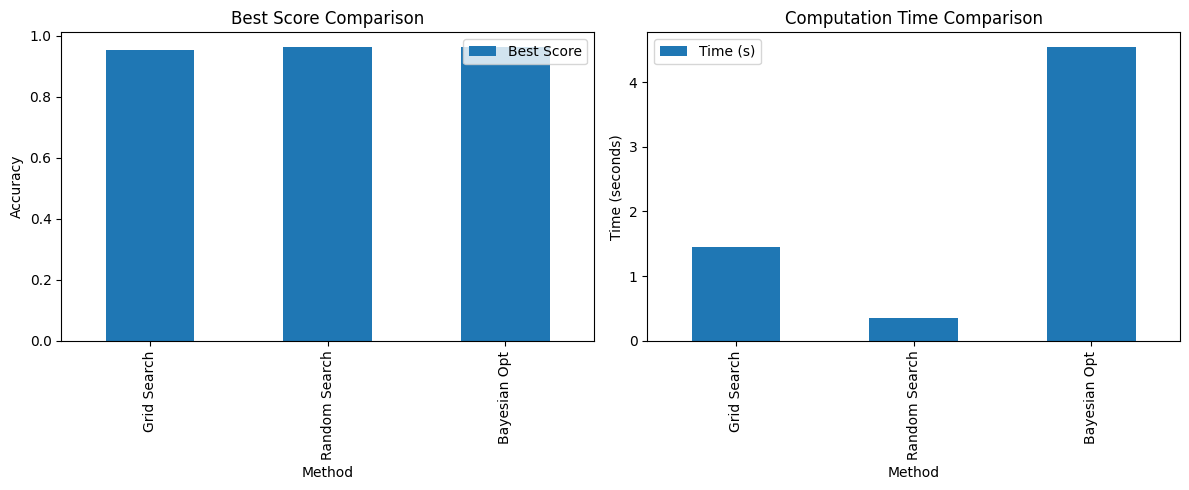

In [7]:
# Run all methods
grid_results = grid_search_cv()
random_results = random_search_cv()
bayesian_results = bayesian_optimization()

# Create comparison DataFrame
results_df = pd.DataFrame({
    'Method': ['Grid Search', 'Random Search', 'Bayesian Opt'],
    'Best Score': [grid_results[1], random_results[1], bayesian_results[1]],
    'Time (s)': [grid_results[2], random_results[2], bayesian_results[2]]
})

print("Results Comparison:")
print(results_df)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

results_df.plot(x='Method', y='Best Score', kind='bar', ax=ax1)
ax1.set_title('Best Score Comparison')
ax1.set_ylabel('Accuracy')

results_df.plot(x='Method', y='Time (s)', kind='bar', ax=ax2)
ax2.set_title('Computation Time Comparison')
ax2.set_ylabel('Time (seconds)')

plt.tight_layout()
plt.show()